# Forecasting Ride Sharing Prices with Time Series Data
## Deep Learning with TensorFlow

![tf](https://lh3.googleusercontent.com/Ns1ea98duQ9csaHN7EQjl6SbnLMxg_ou9bLhZA8KLqbeSv7gg7XXGX1rqtWXgnjiJjBQpiTZWyxIhtxjnWPKTM27-J9T0QI=s688)

Deep learning is a machine learning technique that teaches computers to do what comes naturally to humans: learn by example. Deep usually means the number of hidden layers in the neural network. The layers of deep networks can be more than 150. Deep learning models are trained by using large sets of labeled data and neural network architectures that learn features directly from the data without the need for manual feature extraction. The flow of the deep learning is shown as in the figure below. 

![neural networks](https://i.stack.imgur.com/OH3gI.png)

## Contents

- [Recurrent Neural Network](#Recurrent-Neural-Network)
- [Long Short Term Memory](#Long-Short-Term-Memory)
- [Retrieving the Data](#Retrieving-the-Data)
- [Baseline TensorFlow Model](#Baseline-TensorFlow-Model)
- [Hyperparameter Tuning 1](#Let's-Try-ReLU-as-the-Activation-Function)
- [Hyperparameter Tuning 2](#Let's-try-Adadelta-as-the-Optimizer)
- [Hyperparameter Tuning 3](#Let's-try-Changing-the-Number-of-Hidden-Neurons-from-500-to-100)
- [Hyperparameter Tuning 4](#Let's-Try-to-Initialize-Our-Network-with-LSTM-recurrent-network-cell)
- [Conclusion](#Conclusion)

### Recurrent Neural Network
RNN is Recurrent Neural Networks and we use this algorithm as one of our research methods: The idea behind RNNs is to make use of sequential information. In a traditional neural network, we assume that all inputs (and outputs) are independent of each other [2]. However, this doesn’t work when we try to predict something based on the previous information. So, we introduce RNN as a new method. RNNs are called recurrent because they perform the same task for every element of a sequence, with the output being depended on the previous computations. RNN also has e a “memory” which captures information about what has been calculated so far. Here is what a typical RNN looks like in the following figure.

![rnn](http://www.wildml.com/wp-content/uploads/2015/09/rnn.jpg)

This diagram shows a RNN which is being unrolled into a full network. By unrolling we simply mean that we write out the network for the complete sequence. The hidden state St as the memory of the network which captures information about what happened in all the previous time steps. In this notebook, we'll be using TensorFlow. TensorFlow is an open-source software library for dataflow programming across a range of tasks. It is a symbolic math library, and is also used for machine learning applications such as neural networks.

### Long Short Term Memory
LSTM (Long Short Term Memory networks) don’t have a fundamentally different architecture from RNNs, but they use a different function to compute the hidden state. [3] The memory in LSTMs are called cells and they are used to take the from previous state input and current input. Internally these cells decide what to keep in memory. They then combine the previous state, the current memory, and the input. LSTMs are explicitly designed to avoid the long-term dependency problem as they can remember information for long periods of time. LSTM have chain like structure, but the repeating module has a different structure. There are four neural network layers in LSTM as shown in the following figures.

![lstm](https://www.altoros.com/blog/wp-content/uploads/2017/05/text-prediction-with-tensoflow-and-long-short-term-memory-in-six-steps-v111.gif)

In the above diagram, each line carries an entire vector, from the output of one node to the inputs of others. The circles represent pointwise operations, while the boxes are learned neural network layers. The key to LSTMs is the cell state which is kind of like a conveyor belt, the horizontal line running through the top of the diagram. It’s very easy for information to just flow along it unchanged.


In this notebook, we'll be using __TensorFlow__. TensorFlow is an open-source software library for dataflow programming across a range of tasks. It is a symbolic math library, and is also used for machine learning applications such as neural networks.

In [2]:
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

### Retrieving the Data

Usually, about 80% of the time spent on a data science project is getting and cleaning data. But thankfully for you readers the data we need is up on __[Mandy Yang's GitHub](https://github.com/MandyYang86/Ride-Optimization/tree/master/Merge%20Data)__.

First, we import the required libraries and read the data with pandas' read_csv function.

In [3]:
df1 = pd.read_csv('https://raw.githubusercontent.com/MandyYang86/Ride-Optimization/master/Merge%20Data/uber_pool_March.csv')
df2 = pd.read_csv('https://raw.githubusercontent.com/MandyYang86/Ride-Optimization/master/Merge%20Data/lyft_line_March.csv')
df1.head()

,date_time,date,day,uber_distance,uber_duration,uber_estimate,uber_high_estimate,uber_low_estimate,main_temp,time,weather,uber_price_per_second
0,2018-03-01 00:00:03,1-Mar-18,Thursday,1.73,360,7.5,9.0,6.0,46.69,0:00:03,Rain,0.020833
1,2018-03-01 00:01:03,1-Mar-18,Thursday,1.90,480,5.5,7.0,4.0,46.69,0:01:03,Rain,0.011458
2,2018-03-01 00:02:03,1-Mar-18,Thursday,2.26,420,7.0,9.0,5.0,46.56,0:02:03,Rain,0.016667
3,2018-03-01 00:03:02,1-Mar-18,Thursday,1.63,360,7.5,9.0,6.0,46.56,0:03:02,Rain,0.020833
4,2018-03-01 00:04:02,1-Mar-18,Thursday,2.17,480,9.5,11.0,8.0,46.56,0:04:02,Rain,0.019792


In [6]:
df1.columns # showing all the columns

Index(['date_time', 'date', 'day', 'uber_distance', 'uber_duration',
       'uber_estimate', 'uber_high_estimate', 'uber_low_estimate', 'main_temp',
       'time', 'weather', 'uber_price_per_second'],
      dtype='object')

In [7]:
df1.shape # showing the shape of the dataframe

(44434, 12)

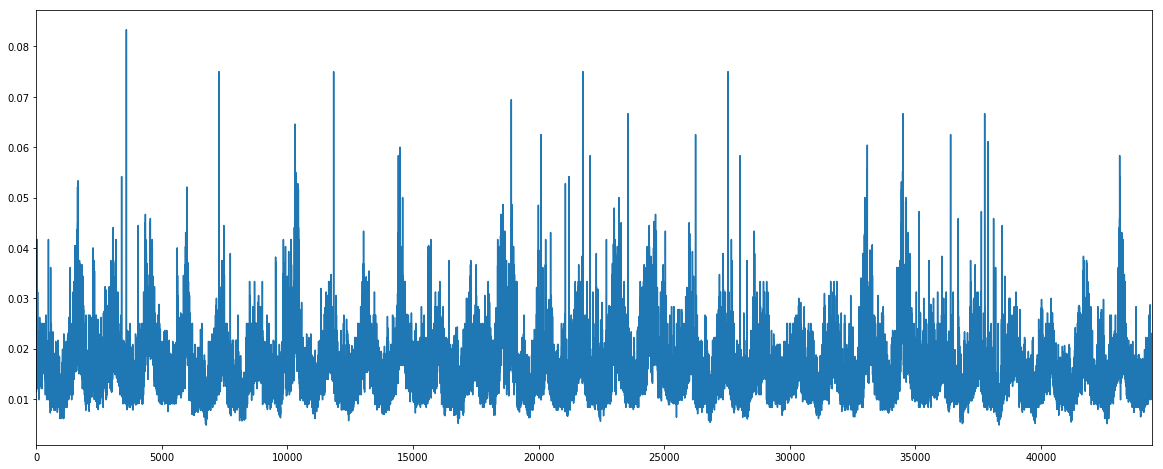

In [8]:
# plotting a basic plot on uber price
plt.figure(figsize=(20, 8))
df1['uber_price_per_second'].plot()

Convert data into array that can be broken up into training "batches" that we will feed into our RNN model. Note the shape of the arrays.

In [9]:
TS = np.array(df1['uber_price_per_second'])
num_periods = 100
f_horizon = 1 # forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS) % num_periods))] # setting up x_data
x_batches = x_data.reshape(-1, 100, 1) # reshaping the dimensions

y_data = TS[1:(len(TS)-(len(TS) % num_periods)) + f_horizon] # setting up y_data
y_batches = y_data.reshape(-1, 100, 1) # reshaping the dimensions
print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:2])

print(y_batches[0:1])
print(y_batches.shape)

444
(444, 100, 1)
[[[ 0.02083333]
  [ 0.01145833]
  [ 0.01666667]
  [ 0.02083333]
  [ 0.01979167]
  [ 0.01527778]
  [ 0.01547619]
  [ 0.02083333]
  [ 0.01833333]
  [ 0.01388889]
  [ 0.01527778]
  [ 0.02083333]
  [ 0.01805556]
  [ 0.0125    ]
  [ 0.01833333]
  [ 0.01875   ]
  [ 0.02222222]
  [ 0.01770833]
  [ 0.01904762]
  [ 0.01597222]
  [ 0.01388889]
  [ 0.01309524]
  [ 0.01296296]
  [ 0.01527778]
  [ 0.04166667]
  [ 0.01354167]
  [ 0.02083333]
  [ 0.01833333]
  [ 0.01805556]
  [ 0.01458333]
  [ 0.01547619]
  [ 0.01944444]
  [ 0.01904762]
  [ 0.01547619]
  [ 0.01875   ]
  [ 0.02083333]
  [ 0.02261905]
  [ 0.01851852]
  [ 0.01904762]
  [ 0.02083333]
  [ 0.01515152]
  [ 0.02166667]
  [ 0.01354167]
  [ 0.01282051]
  [ 0.01666667]
  [ 0.01805556]
  [ 0.01785714]
  [ 0.01354167]
  [ 0.01875   ]
  [ 0.01527778]
  [ 0.02083333]
  [ 0.02083333]
  [ 0.03125   ]
  [ 0.01354167]
  [ 0.01875   ]
  [ 0.015     ]
  [ 0.01805556]
  [ 0.01785714]
  [ 0.0225    ]
  [ 0.01527778]
  [ 0.01875   ]
  [ 0.

We have 44434 total observations in our data. We want to make sure we have the same number of observations for each of our batch inputs.

What we see is our training data set is made up of 444 batches, containing about 100 observations. Each observation is a sequence of a single value.

The next step is to pull out our data.

In [10]:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):] # setting up x test
    testX = test_x_setup[:num_periods].reshape(-1, 100, 1) # reshaping our test sets
    testY = TS[-(num_periods):].reshape(-1, 100, 1)
    return testX, testY

X_test, Y_test = test_data(TS, f_horizon, num_periods)
print(X_test.shape)
print(X_test)

(1, 100, 1)
[[[ 0.01527778]
  [ 0.01428571]
  [ 0.01287879]
  [ 0.01136364]
  [ 0.01309524]
  [ 0.0225    ]
  [ 0.0125    ]
  [ 0.02321429]
  [ 0.01666667]
  [ 0.01666667]
  [ 0.02222222]
  [ 0.02651515]
  [ 0.01410256]
  [ 0.01354167]
  [ 0.0287037 ]
  [ 0.02371795]
  [ 0.01666667]
  [ 0.01416667]
  [ 0.01666667]
  [ 0.0125    ]
  [ 0.01388889]
  [ 0.01666667]
  [ 0.01060606]
  [ 0.01060606]
  [ 0.01916667]
  [ 0.02045455]
  [ 0.01282051]
  [ 0.01428571]
  [ 0.0125    ]
  [ 0.01309524]
  [ 0.01666667]
  [ 0.02314815]
  [ 0.01742424]
  [ 0.01203704]
  [ 0.02166667]
  [ 0.01388889]
  [ 0.02      ]
  [ 0.02083333]
  [ 0.01547619]
  [ 0.00984848]
  [ 0.01222222]
  [ 0.02083333]
  [ 0.01488095]
  [ 0.01666667]
  [ 0.01666667]
  [ 0.0202381 ]
  [ 0.01136364]
  [ 0.01602564]
  [ 0.015     ]
  [ 0.02083333]
  [ 0.015625  ]
  [ 0.015     ]
  [ 0.01770833]
  [ 0.01282051]
  [ 0.01515152]
  [ 0.01527778]
  [ 0.015625  ]
  [ 0.01363636]
  [ 0.01111111]
  [ 0.01851852]
  [ 0.01845238]
  [ 0.014583

### Baseline TensorFlow Model

Now that we have our data, let’s create our TensorFlow graph that will do the computation.

In [11]:
tf.reset_default_graph() # we didn't have any previous graph objects running, but this would reset the graphs

num_periods = 100 # number of periods per vector we are using to predict one period ahead
inputs = 1        # number of vectors submitted
hidden = 500      # number of neurons we will recursively work through, can be changed to improve accuracy
output = 1        # number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs]) # A placeholder exists solely to serve as the target of feeds
y = tf.placeholder(tf.float32, [None, num_periods, output]) # It is not initialized and contains no data

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.sigmoid) # create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32) # choose dynamic over static

learning_rate = 0.001 # small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden]) # change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output) # specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output]) # shape of the results

loss = tf.reduce_sum(tf.square(outputs - y)) # define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # gradient descent method
training_op = optimizer.minimize(loss) # train the result of the application of the cost_function

init = tf.global_variables_initializer() # initialize all the variables

We are specifying the number of periods we are using to predict. In this case, it is the number of sequences that we are feeding into the model as a single input. We specify our variable placeholders. We initialize a type of RNN cell to use (size 500) and the type of activation function we want. ReLU stands for “Rectified Linear Unit” and is the default activation function, but it can be changed to Sigmoid, Hyberbolic Tangent (Tanh), and others, if desired. In this case we're using Sigmoid.

We want our outputs to be in the same format as our inputs so we can compare our results using the loss function. In this case, we are using mean squared error (MSE), since this is a regression problem, in which our goal is to minimize the difference between the actual and the predicted. If we were dealing with a classification outcome, we might use cross-entropy. Now that we have this loss function defined, it is possible to define the training operation in TensorFlow that will optimize our network of input and outputs. To execute the optimization, we will use the Adam optimizer. Adam optimizer is a great general-purpose optimizer that performs our gradient descent via backpropagation through time. This allows faster convergence at the cost of more computation.

Now it is time to implement this model on our training data.

In [12]:
epochs = 1000 # number of iterations or training cycles, includes both the feedforward and backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches}) # Supply feed data through the feed_dict argument
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, '\tMSE:', mse)
            
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 160084.0
100 	MSE: 6.66884
200 	MSE: 1.69661
300 	MSE: 1.57335
400 	MSE: 1.54967
500 	MSE: 1.53245
600 	MSE: 1.51779
700 	MSE: 1.50486
800 	MSE: 1.49293
900 	MSE: 1.48142
[[[ 0.01593456]
  [ 0.01620695]
  [ 0.0155004 ]
  [ 0.01851162]
  [ 0.01520106]
  [ 0.01657376]
  [ 0.01596376]
  [ 0.01643535]
  [ 0.01613805]
  [ 0.01617369]
  [ 0.01637468]
  [ 0.01649603]
  [ 0.01602599]
  [ 0.01607761]
  [ 0.01662526]
  [ 0.01635787]
  [ 0.01613387]
  [ 0.01608619]
  [ 0.01618978]
  [ 0.01602551]
  [ 0.01609835]
  [ 0.0161911 ]
  [ 0.01595768]
  [ 0.01599166]
  [ 0.01629922]
  [ 0.0162954 ]
  [ 0.01601419]
  [ 0.01611099]
  [ 0.01603934]
  [ 0.01606926]
  [ 0.01619503]
  [ 0.01640627]
  [ 0.01616499]
  [ 0.01600382]
  [ 0.016381  ]
  [ 0.01604614]
  [ 0.01630947]
  [ 0.01630566]
  [ 0.01610765]
  [ 0.01593694]
  [ 0.01605448]
  [ 0.01634929]
  [ 0.01608548]
  [ 0.01618454]
  [ 0.01617536]
  [ 0.01630244]
  [ 0.01596376]
  [ 0.0161812 ]
  [ 0.01611885]
  [ 0.01633283]
  [ 0.01611397]
  [ 0

We specify the number of iterations/epochs that will cycle through our batches of training sequences. We create our graph object (tf.Session()) and initialize our data to be fed into the model as we cycle through the epochs. The abbreviated output shows the MSE after each 100 epochs. As our model feeds the data forward and backpropagation runs, it adjusts the weights applied to the inputs and runs another training epoch. Our MSE continues to improve (decrease). Finally, once the model is done, it takes the parameters and applies them to the test data to give us our predicted output for Y.

We can see that the initial epochs have a high MSE at 160,000 and starts to reach a plateau at around 1.5 after 300 epochs. Remember the mean squared error, where smaller values are better and 0.0 means perfect prediction. Let’s check our predicted versus actual. For our test data, we were focused on the last 444 periods of the entire 44434 periods.

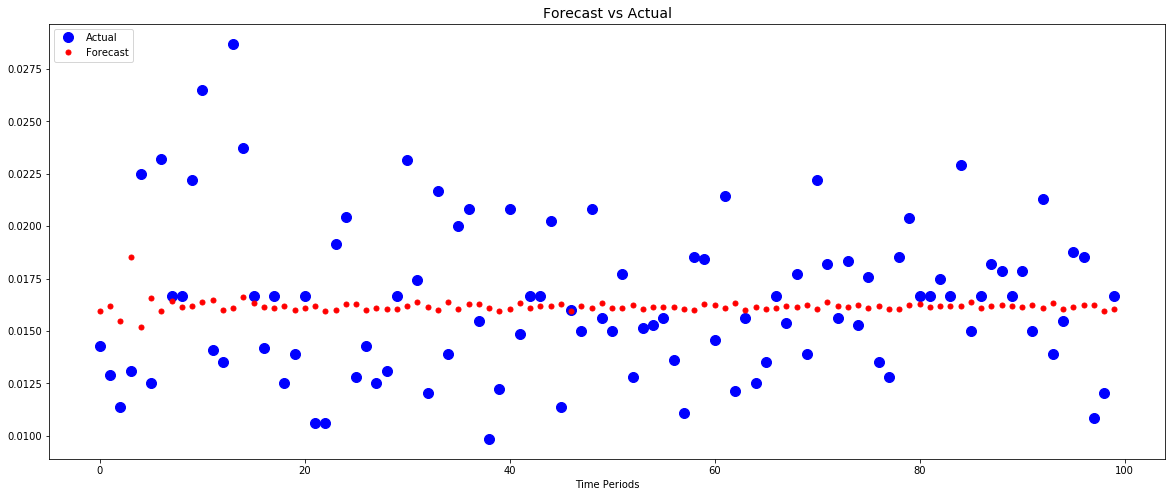

In [13]:
# plotting actual vs forecasted results
plt.figure(figsize=(20, 8))
plt.title('Forecast vs Actual', fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'bo', markersize=10, label='Actual')
plt.plot(pd.Series(np.ravel(y_pred)), 'r.', markersize=10, label='Forecast')
plt.legend(loc='upper left')
plt.xlabel('Time Periods')
plt.show()

It would appear there is some room for improvement. However, this can be done by changing the number of hidden neurons and/or increasing the number of epochs. Optimizing our model is a process of trial and error, but we have a great start. The next steps would be to tune the hyperparaters to reach optimization.

### Let's Try ReLU as the Activation Function

In [26]:
tf.reset_default_graph() # we didn't have any previous graph objects running, but this would reset the graphs

num_periods = 100 # number of periods per vector we are using to predict one period ahead
inputs = 1        # number of vectors submitted
hidden = 500     # number of neurons we will recursively work through, can be changed to improve accuracy
output = 1        # number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs]) # create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu) # create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32) # choose dynamic over static

learning_rate = 0.001 # small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden]) # change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output) # specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output]) # shape of the results

loss = tf.reduce_sum(tf.square(outputs - y)) # define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # gradient descent method
training_op = optimizer.minimize(loss) # train the result of the application of the cost_function

init = tf.global_variables_initializer() # initialize all the variables

In [27]:
epochs = 1000 # number of iterations or training cycles, includes both the feedforward and backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, '\tMSE:', mse)
            
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 1.39891
100 	MSE: 0.755908
200 	MSE: 0.726688
300 	MSE: 0.725156
400 	MSE: 0.729768
500 	MSE: 0.753929
600 	MSE: 0.719833
700 	MSE: 0.717097
800 	MSE: 0.711599
900 	MSE: 0.711923
[[[ 0.01566341]
  [ 0.01546943]
  [ 0.01433646]
  [ 0.0136351 ]
  [ 0.01332745]
  [ 0.0146356 ]
  [ 0.01418727]
  [ 0.0153909 ]
  [ 0.01533382]
  [ 0.01539922]
  [ 0.01622156]
  [ 0.01743055]
  [ 0.01671918]
  [ 0.01640568]
  [ 0.01793189]
  [ 0.01840511]
  [ 0.01800387]
  [ 0.01751714]
  [ 0.0174351 ]
  [ 0.01673162]
  [ 0.01646203]
  [ 0.01645198]
  [ 0.01568059]
  [ 0.01512001]
  [ 0.01562877]
  [ 0.01611784]
  [ 0.01564996]
  [ 0.01553506]
  [ 0.01514193]
  [ 0.01489508]
  [ 0.01510392]
  [ 0.01602282]
  [ 0.01607877]
  [ 0.01554627]
  [ 0.01631795]
  [ 0.01588784]
  [ 0.0164136 ]
  [ 0.01689655]
  [ 0.01661836]
  [ 0.01574574]
  [ 0.01538513]
  [ 0.01600547]
  [ 0.01579476]
  [ 0.01590345]
  [ 0.01596212]
  [ 0.01644726]
  [ 0.01571694]
  [ 0.01582783]
  [ 0.01566276]
  [ 0.01627378]
  [ 0.0161250

The initial epochs have a low MSE at 1.39891 and quickly reach a plateau at around 0.7 after 100 epochs.

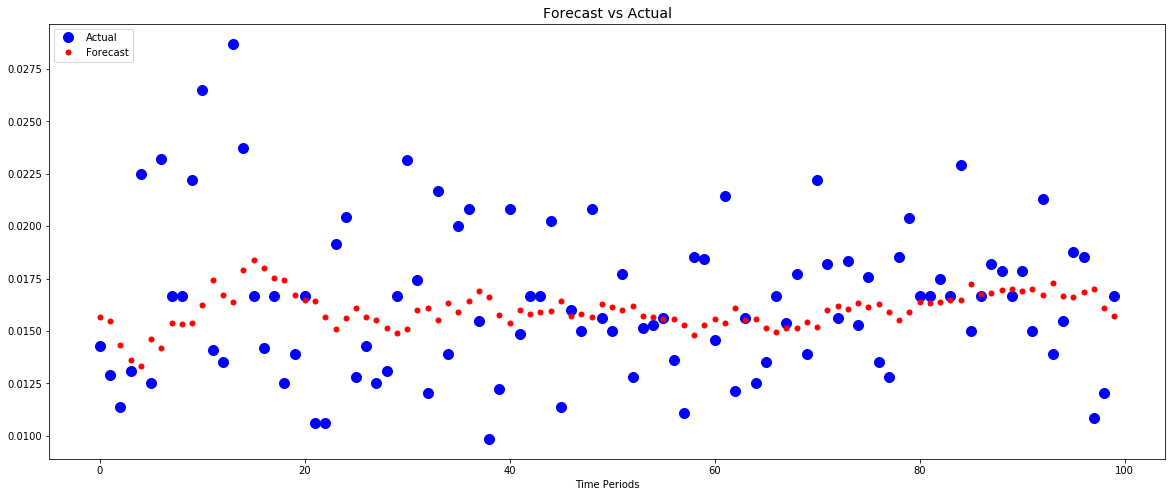

In [28]:
# plotting actual vs forecasted results
plt.figure(figsize=(20, 8))
plt.title('Forecast vs Actual', fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'bo', markersize=10, label='Actual')
plt.plot(pd.Series(np.ravel(y_pred)), 'r.', markersize=10, label='Forecast')
plt.legend(loc='upper left')
plt.xlabel('Time Periods')
plt.show()

### Let's try Adadelta as the Optimizer

In [29]:
tf.reset_default_graph() # we didn't have any previous graph objects running, but this would reset the graphs

num_periods = 100 # number of periods per vector we are using to predict one period ahead
inputs = 1        # number of vectors submitted
hidden = 500     # number of neurons we will recursively work through, can be changed to improve accuracy
output = 1        # number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs]) # create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu) # create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32) # choose dynamic over static

learning_rate = 0.001 # small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden]) # change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output) # specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output]) # shape of the results

loss = tf.reduce_sum(tf.square(outputs - y)) # define the cost function which evaluates the quality of our model
optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate) # gradient descent method
training_op = optimizer.minimize(loss) # train the result of the application of the cost_function

init = tf.global_variables_initializer() # initialize all the variables

In [30]:
epochs = 1000 # number of iterations or training cycles, includes both the feedforward and backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, '\tMSE:', mse)
            
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 13.4863
100 	MSE: 9.23401
200 	MSE: 1.35152
300 	MSE: 1.0944
400 	MSE: 0.926838
500 	MSE: 0.872262
600 	MSE: 0.84669
700 	MSE: 0.821666
800 	MSE: 0.796327
900 	MSE: 0.784093
[[[ 0.01080578]
  [ 0.01557988]
  [ 0.01594589]
  [ 0.01623733]
  [ 0.01584935]
  [ 0.01586946]
  [ 0.01589579]
  [ 0.01607771]
  [ 0.01611299]
  [ 0.0167907 ]
  [ 0.01709188]
  [ 0.01804273]
  [ 0.01870858]
  [ 0.01849037]
  [ 0.01861166]
  [ 0.01969504]
  [ 0.02019918]
  [ 0.01953769]
  [ 0.01914303]
  [ 0.01864512]
  [ 0.01790087]
  [ 0.01732323]
  [ 0.01682184]
  [ 0.01604766]
  [ 0.01572749]
  [ 0.01599343]
  [ 0.01621625]
  [ 0.01597507]
  [ 0.01564986]
  [ 0.01552274]
  [ 0.01530644]
  [ 0.01572804]
  [ 0.01638709]
  [ 0.01650755]
  [ 0.01669083]
  [ 0.01673947]
  [ 0.01716689]
  [ 0.01729046]
  [ 0.01773638]
  [ 0.01728541]
  [ 0.01661335]
  [ 0.0164702 ]
  [ 0.01653789]
  [ 0.01647353]
  [ 0.01646591]
  [ 0.01692505]
  [ 0.016775  ]
  [ 0.01667842]
  [ 0.01633066]
  [ 0.01679954]
  [ 0.01678991]
  

The initial epochs have the MSE at 13.4863 and reached a plateau at around 0.8 after 600 epochs.

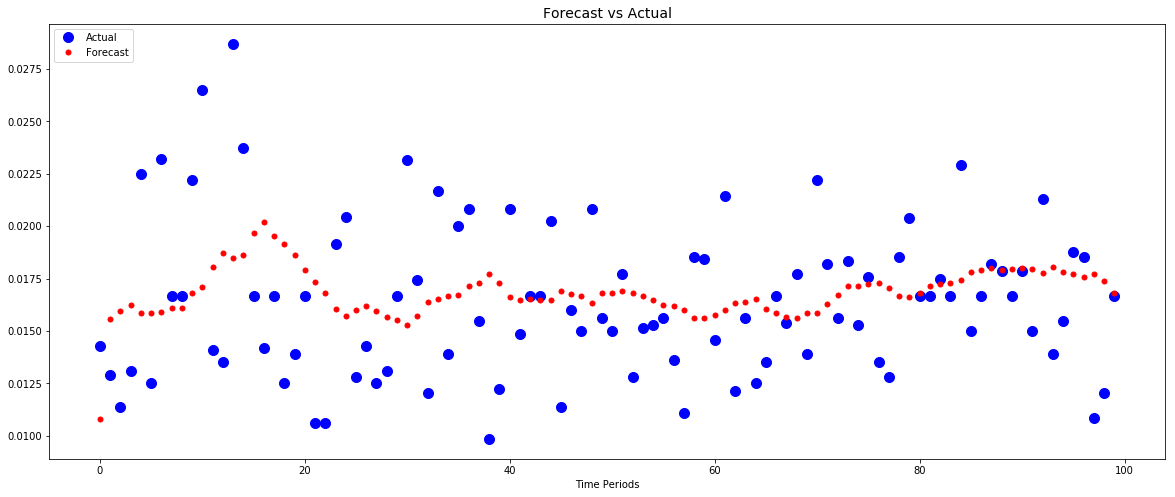

In [31]:
plt.figure(figsize=(20, 8))
plt.title('Forecast vs Actual', fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'bo', markersize=10, label='Actual')
plt.plot(pd.Series(np.ravel(y_pred)), 'r.', markersize=10, label='Forecast')
plt.legend(loc='upper left')
plt.xlabel('Time Periods')
plt.show()

### Let's try Changing the Number of Hidden Neurons from 500 to 100

In [32]:
tf.reset_default_graph() # we didn't have any previous graph objects running, but this would reset the graphs

num_periods = 100 # number of periods per vector we are using to predict one period ahead
inputs = 1        # number of vectors submitted
hidden = 100     # number of neurons we will recursively work through, can be changed to improve accuracy
output = 1        # number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs]) # create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu) # create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32) # choose dynamic over static

learning_rate = 0.001 # small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden]) # change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output) # specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output]) # shape of the results

loss = tf.reduce_sum(tf.square(outputs - y)) # define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # gradient descent method
training_op = optimizer.minimize(loss) # train the result of the application of the cost_function

init = tf.global_variables_initializer() # initialize all the variables

In [33]:
epochs = 1000 # number of iterations or training cycles, includes both the feedforward and backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, '\tMSE:', mse)
            
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 2.41857
100 	MSE: 0.737312
200 	MSE: 0.725699
300 	MSE: 0.721793
400 	MSE: 0.72206
500 	MSE: 0.71966
600 	MSE: 0.723329
700 	MSE: 0.720206
800 	MSE: 0.86659
900 	MSE: 0.726107
[[[ 0.0158736 ]
  [ 0.01609669]
  [ 0.01503614]
  [ 0.01448375]
  [ 0.01450979]
  [ 0.01600876]
  [ 0.0151663 ]
  [ 0.01637627]
  [ 0.01661066]
  [ 0.01668252]
  [ 0.01773637]
  [ 0.01897091]
  [ 0.01821842]
  [ 0.01753764]
  [ 0.01935333]
  [ 0.01994598]
  [ 0.01946393]
  [ 0.01867909]
  [ 0.01833971]
  [ 0.01721346]
  [ 0.01650876]
  [ 0.01654   ]
  [ 0.01542423]
  [ 0.01456374]
  [ 0.01521943]
  [ 0.01587433]
  [ 0.01542764]
  [ 0.01542118]
  [ 0.0150027 ]
  [ 0.01461628]
  [ 0.01488952]
  [ 0.01599422]
  [ 0.01631825]
  [ 0.01576542]
  [ 0.0168113 ]
  [ 0.01629395]
  [ 0.01691649]
  [ 0.01762034]
  [ 0.01723101]
  [ 0.01602939]
  [ 0.01536222]
  [ 0.01609455]
  [ 0.01580956]
  [ 0.01605275]
  [ 0.01629724]
  [ 0.01687906]
  [ 0.01595227]
  [ 0.01603464]
  [ 0.01594636]
  [ 0.01657231]
  [ 0.01646482]


The initial epochs have a low MSE at 2.41857 and quickly reached a plateau at around 0.7 after 100 epochs, although it fluctuates after 800 epochs.

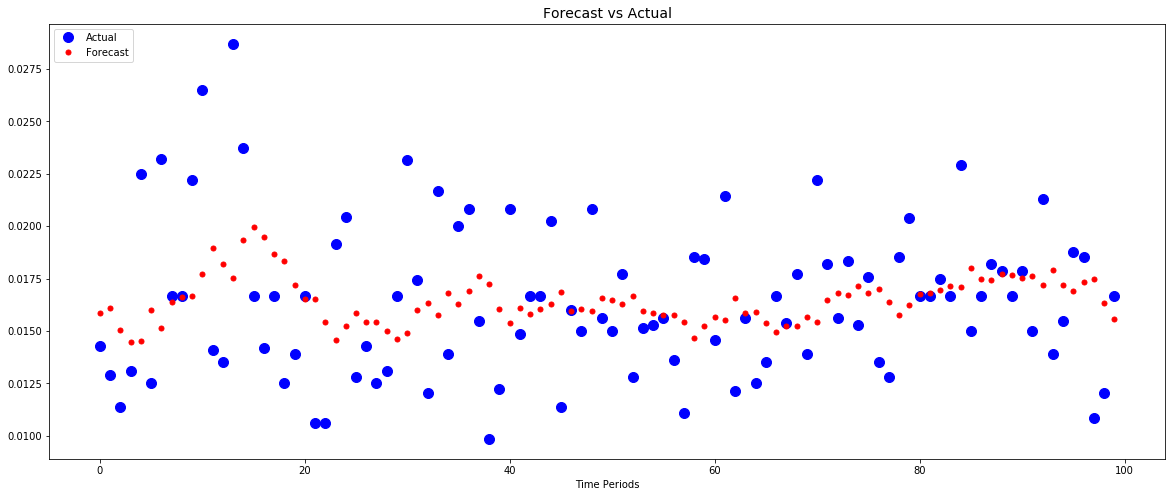

In [34]:
plt.figure(figsize=(20, 8))
plt.title('Forecast vs Actual', fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'bo', markersize=10, label='Actual')
plt.plot(pd.Series(np.ravel(y_pred)), 'r.', markersize=10, label='Forecast')
plt.legend(loc='upper left')
plt.xlabel('Time Periods')
plt.show()

### Let's Try to Initialize Our Network with LSTM recurrent network cell

In [35]:
tf.reset_default_graph() # we didn't have any previous graph objects running, but this would reset the graphs

num_periods = 100 # number of periods per vector we are using to predict one period ahead
inputs = 1        # number of vectors submitted
hidden = 500     # number of neurons we will recursively work through, can be changed to improve accuracy
output = 1        # number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs]) # create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.LSTMCell(num_units = hidden, forget_bias=1.0, initializer=tf.zeros_initializer, activation=tf.nn.relu) # create our LSTM object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32) # choose dynamic over static

learning_rate = 0.001 # small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden]) # change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output) # specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output]) # shape of the results

loss = tf.reduce_sum(tf.square(outputs - y)) # define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # gradient descent method
training_op = optimizer.minimize(loss) # train the result of the application of the cost_function

init = tf.global_variables_initializer() # initialize all the variables

In [36]:
epochs = 1000 # number of iterations or training cycles, includes both the feedforward and backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, '\tMSE:', mse)
            
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 11.7384
100 	MSE: 1.52015
200 	MSE: 1.51987
300 	MSE: 1.51987
400 	MSE: 1.51987
500 	MSE: 1.51987
600 	MSE: 1.51987
700 	MSE: 1.51987
800 	MSE: 1.51987
900 	MSE: 1.51987
[[[ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.01617063]
  [ 0.

The initial epochs have the MSE at 11.7384 and quickly reached a plateau at around 1.51 after 100 epochs.

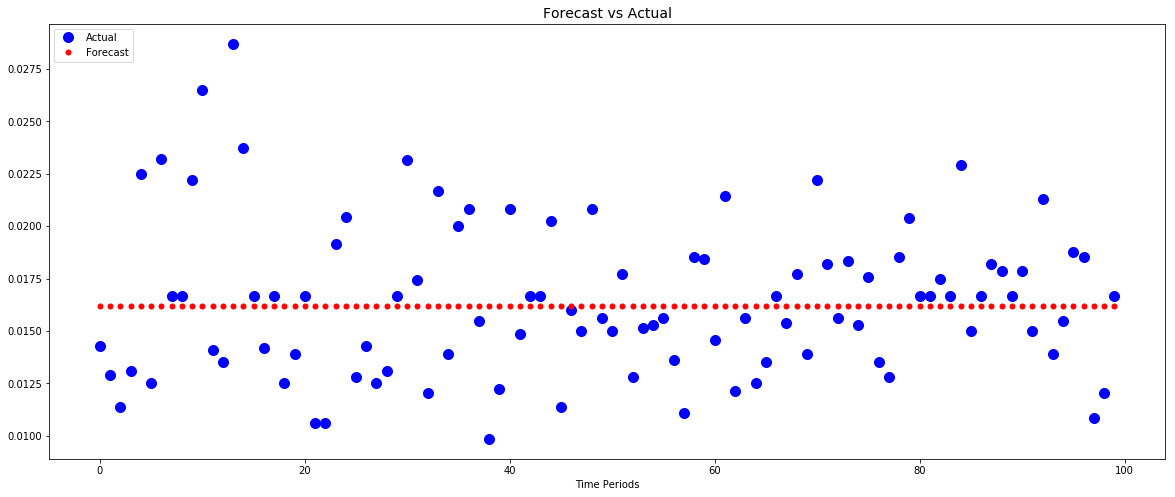

In [37]:
plt.figure(figsize=(20, 8))
plt.title('Forecast vs Actual', fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'bo', markersize=10, label='Actual')
plt.plot(pd.Series(np.ravel(y_pred)), 'r.', markersize=10, label='Forecast')
plt.legend(loc='upper left')
plt.xlabel('Time Periods')
plt.show()

### Conclusion

The best hyperparameter tuning configuration is set with:

- 100 periods per vector 
- 1 input vector
- 500 hidden layers of neurons 
- 1 output vector
- Activation function: ReLU
- Learning rate: 0.001
- Loss function: MSE
- Gradient estimation: Adam Optimizer


![thank you for reading](https://steemit-production-imageproxy-web.s3.amazonaws.com/U5dsCyY1nqNs8vZHBQusqgr5vmHcgrJ)

__Reference__: [TensorFlow | Wikipedia](https://en.wikipedia.org/wiki/TensorFlow)

__Inspired by__: [Deep Learning TensorFlow | MapR](https://mapr.com/blog/deep-learning-tensorflow/)

[Back to the Top!](#Forecasting-Ride-Sharing-Prices-with-Time-Series-Data)